# RL homework 3

-------------------------------


**Name:** Kunqi Jiang

**SN:** 17057761

-----------------------------------


**Start date:** *7th March 2018*

**Due date:** *21st March 2018, 11:55 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw3.ipynb** before the deadline above.

Also send a **sharable link** to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

Please compile all results and all answers to the understanding questions into a PDF. Name convention: **studentnumber_RL_hw3.pdf**. Do not include any of the code (we will use the notebook for that). 

**Page limit: 10 pg **


## Context

In this assignment, we will investigate the properties of 3 distinct reinforcement learning algorithms:

* Online Q-learning
* Experience Replay
* Dyna-Q

We will consider two different dimensions:
* Tabular vs Function Approximation
* Stationary vs Non-Stationary environments

## Background reading

* Sutton and Barto (2018), Chapters 8

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms **[50 pts]**.

You will then run these algorithms on a few problems, to understand their properties.

Finally you will answer a few question about the performance of these algorithms in the various problems **[50pts]**.

# Setup

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

# Grid worlds

**Tabular Grid-World**

Simple tabular grid world.

You can visualize the grid worlds we will train our agents on, by running the cells below.
`S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.

We will use three distinct GridWorlds:
* `Grid` tabular grid world withh a goal in the top right of the grid
* `AltGrid` tabular grid world withh a goal in the bottom left of the grid
* `FeatureGrid` a grid world with a non tabular representation of states, the features are such to allow some degree of state aliasing

In [0]:
#@title Grid
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest",cmap="pink")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()

In [0]:
#@title AltGrid
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

In [0]:
#@title FeatureGrid
class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return np.array(features).reshape([len(features),1]) / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

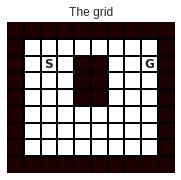

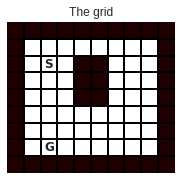

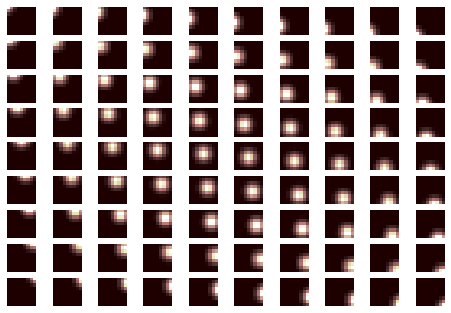

In [6]:

# Instantiate the two tabular environments
grid = Grid()
alt_grid = AltGrid()

# Plot tabular environments
grid.plot_grid()
alt_grid.plot_grid()

# Instantiate the non tabular version of the environment.
feat_grid = FeatureGrid()

# Plot the features of each state
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])

for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)), interpolation='nearest',cmap="pink")
  ax.set_xticks([])
  ax.set_yticks([])

# Helper functions

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
def random_policy(q):
  return np.random.randint(4)

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.hold('on')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

# Part 1: Implement Agents

Each agent, should implement a step function:

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `q_values()`:

Tabular agents implement a function `q_values()` returning a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

### `q_values(state)`:

Agents with Linear function approximation implement a method `q_values(state)` returning an array of Q values of shape: (`number_of_actions`)


### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  As in the previous assignment you can use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Q-learning and it's variants needs to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._action = 0
  (...)
```



# Part 1: Implement Agents

We are going to implement 5 agent:
- Online Tabular Q-learning
- Tabular Experience Replay
- Tabular Dyna-Q (with a Tabular model)
- Experience Replay with linear function approximation
- Dyna-Q with linear function approximation (with a linear model)



## 1.1 Tabular Model
**[5 pts]** Implement a trainable tabular Model of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

Given that the environment is deterministic and tabular the model will basically reduce to a simple lookup table.

In [0]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self.reward_table = np.zeros([number_of_states, number_of_actions])
    self.next_state_table = np.zeros([number_of_states, number_of_actions])
    self.discount_table = np.zeros([number_of_states, number_of_actions])    

  def next_state(self, state, action):
    return self.next_state_table[state,action]
  
  def reward(self, state, action):
    
    return self.reward_table[state,action]
    
  def discount(self, state, action):
    
    return self.discount_table[state,action]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    self.next_state_table[state,action] = next_state
    self.reward_table[state,action] = reward
    self.discount_table[state,action] = discount

## 1.2 Linear Model

**[5 pts]** Implement a trainable linear model of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward, discount and next state will all be a linear function of the state.
* $\text{s'} = T_a s$
* $\text{r'} = R_a s$
* $\text{g'} = G_a s$

Where $T_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $R_a$ and $G_a$are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by gradient descent. Write down the update to the parameters of the models and implement the update in the model below.



In [0]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self.state_weight = np.random.rand(number_of_actions,number_of_features, number_of_features)
    self.reward_weight = np.random.rand(number_of_actions, 1,number_of_features)
    self.discount_weight = np.random.rand(number_of_actions, 1,number_of_features)
    

  def next_state(self, s, a):
    return self.state_weight[a] @ s
  
  def reward(self, s, a):
    return self.reward_weight[a] @ s

  def discount(self, s, a):
    return self.discount_weight[a] @ s

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):

    state_error = next_state - self.next_state(state, action)
    discount_error =  discount - self.discount(state, action)
    reward_error = reward - self.reward(state, action)
    print('state',state_error)
    print('discount_error', discount_error)
    print("reward_error", reward_error)
    #print("state", (step_size * state_error @ state.T).shape)
    #print("discount", (step_size * reward_error @ state.T).shape)
    #print("reward", (step_size * discount_error @ state.T).shape)
    self.state_weight[action] += step_size * state_error * state.T
    self.reward_weight[action] += step_size * reward_error * state.T
    self.discount_weight[action] += step_size * discount_error * state.T

## 1.3 Experience Replay

**[10 pts]** Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning 
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A, R, \gamma, S' \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
 class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self.q_values = np.zeros((number_of_states, number_of_actions))
    self.state = initial_state
    self.step_size = step_size
    self.action = 0
    self.replayBuffer = []
    self.plan_step = num_offline_updates
    self.behaviour_policy = behaviour_policy
    
  @property
  def q_value(self):
    return self.q_values

  def step(self, reward, discount, next_state):
    self.replayBuffer.append((self.state,self.action,reward,discount,next_state))
    current_value = self.q_values[self.state, self.action]
    self.q_values[self.state, self.action] += self.step_size * (reward + discount * max(self.q_values[next_state,:]) - current_value)
 
    self.state = next_state                                                            
    self.action = self.behaviour_policy(self.q_value[self.state])
    # replay planning
    for i in range(self.plan_step):
      rand = np.random.randint(len(self.replayBuffer))
      state, action, reward, discount, next_state = self.replayBuffer[rand]
      to_update_value = self.q_values[state,action]                                                         
      temp_diff = (reward + discount * max(self.q_values[next_state,:]) - to_update_value)
      self.q_values[state,action] += self.step_size * temp_diff                                                        
                                                                
    return self.action
    


## 1.4 Dyna-Q
**[10 pts]** Implement an agent that uses **Dyna-Q** to learn action values.  
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A)$

6. $\text{Model}.\text{update}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  2. $R, \gamma, S' \gets \text{Model}.\text{transition}(S, A)$
  
  3. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions,initial_state, model, 
       behaviour_policy, num_offline_updates, step_size=0.1):
    
    
    self.q_values = np.zeros([number_of_states, number_of_actions])
    self.state = initial_state
    self.model = model
    self.action = 0
    self.plan_step = num_offline_updates
    self.step_size = step_size
    self.replayBuffer = []
    self.behaviour_policy = behaviour_policy
    
  @property
  def q_value(self):
    return self.q_values

  def step(self, reward, discount, next_state):
    
    current_value = self.q_values[self.state, self.action]
    self.q_values[self.state, self.action] += self.step_size * (reward + discount * max(self.q_values[next_state,:]) - current_value)
    self.model.update(self.state,self.action,reward,discount,next_state)                                                         
    self.state = next_state                                                            
    self.action = self.behaviour_policy(self.q_values[next_state])
    #self.action = np.argmax(self.q_values[next_state])
    #self.action = np.random.randint(4)
    self.replayBuffer.append((self.state, self.action))
                                                            
    # replay planning
    for i in range(self.plan_step):
      rand = np.random.randint(len(self.replayBuffer))
      state, action = self.replayBuffer[rand]
      reward, discount, next_state = self.model.transition(state,action)                                                     
      to_update_value = self.q_values[state,action]  
      temp_diff = (reward + discount * max(self.q_values[int(next_state)]) - to_update_value)
      self.q_values[state,action] += self.step_size * temp_diff                                                        
    return self.action                                  

## 1.5 Experience Replay with Linear Function Approximation

**[10 pts]** Implement an agent that uses **Experience Replay** to learn action values as a linear function approximation over a given set of features.

**Training**: To make sure of the experience in an online fashion, we will learn this linear model via gradient descent. Write down the update to the parameters of the value function and implement the update in the agent below.

In [0]:
class FeatureExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    
    self.q_net = np.random.rand(number_of_actions, number_of_features)
    

  def q(self, state):
    return self.q_net @ state
  
  def update_weight(self, state, action, reward, discount, next_state):
    error = reward + discount * np.max(self.q(next_state)) - self.q_net[action] @ state
    self.q_net[action] += 0.001 * error @ self.state.T
    
  def step(self, reward, discount, next_state):
    self.replayBuffer.append((self.state, self.action, reward, discount, next_state))
    # here self.state is always state features received from get_obs
    self.update_weight(self.state, self.action, reward, discount, next_state)
    online_q_values = self.q(self.state)
    
    self.action = self.behaviour_policy(online_q_values)
    
    self.state = next_state
    
    for i in range(self.plan_step):
      rand = np.random.randint(len(self.replayBuffer))
      state, action, reward, discount, next_state = self.replayBuffer[rand]
      self.update_weight(state, action, reward, discount, next_state)
    return self.action
   


## 1.6 Dyna-Q with Linear Function Approximation

**[10 pts]** Implement an agent that uses **Dyna-Q** that uses a linear function approximation to represent the value functions and a learnt linear model of the environment (represent and learn both the **transition model**(action conditioned) and the **reward model** as linear transformations of the given set of features).  
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition, use a step_size of 0.01
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A)$

6. $\text{Model}.\text{update}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  2. $R, \gamma, S' \gets \text{Model}.\text{transition}(S, A)$
  
  3. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
class FeatureDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    
    self.q_net = np.random.rand(number_of_actions, number_of_features)
   
  def q(self, state):
    return self.q_net @ state
  
  def update_q_net(self, state, action, reward, discount, next_state):
    error = reward + discount * np.max(self.q(next_state)) - self.q_net[action] @ state
    # error is a vector [error] use @
    self.q_net[action] += 0.1 * error.reshape(1,) @ state.T
    
  def step(self, reward, discount, next_state):
    
    self.update_q_net(self.state, self.action, reward, discount, next_state)
    self.replayBuffer.append((self.state, self.action))
    self.model.update(self.state, self.action, reward, discount, next_state)
    self.state = next_state
    self.action = self.behaviour_policy(self.q(self.state))
    
    for i in range(self.plan_step):
      rand = np.random.randint(len(self.replayBuffer))
      state, action = self.replayBuffer[rand]
      reward, discount, next_state = self.model.transition(state, action)
      #print('reward', reward)
      #print('discount', discount)
      #print('next state', next_state)
      self.update_q_net(state, action, reward, discount, next_state)
 
    return self.action

# Assignment 2: Analyse Results

## 2.1 Tabular Learning

### 2.1.1 Data Efficiency

**Online Q-learning**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

In [0]:
def epsilon_policy(q):
  if np.random.rand() > 0.1:
    return np.argmax(q)
  else:
    return np.random.randint(4)

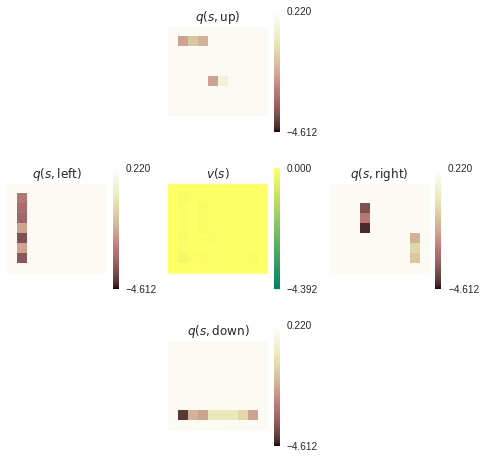

In [19]:
grid = Grid()

agent = ExperienceQ(grid._layout.size,4, grid.get_obs(),random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

**Experience Replay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.6/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


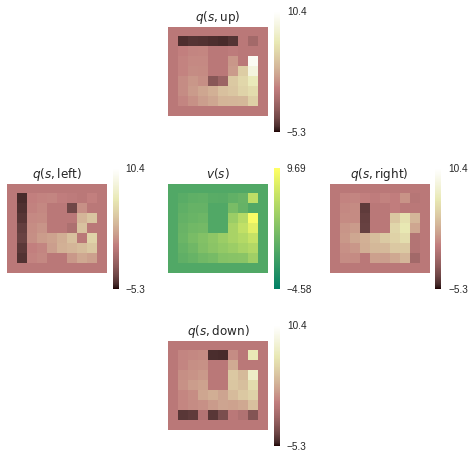

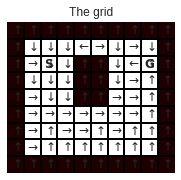

In [90]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

**DynaQ**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

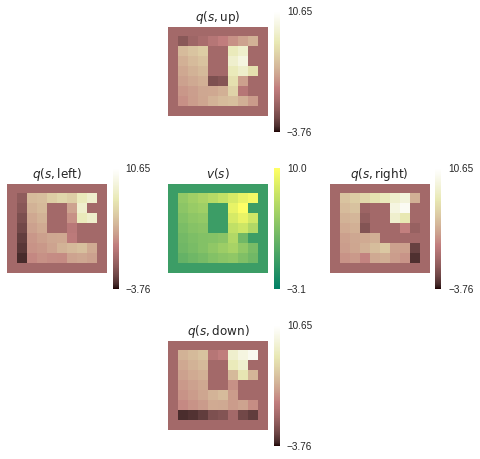

In [77]:
grid = Grid()
dyna_model = TabularModel(grid._layout.size, 4)

def behaviour_policy(q):
  if np.random.rand() > 0.1:
    return np.argmax(q)
  else:
    return np.random.randint(4)

agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(), dyna_model,
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### 2.1.2 Computational Cost

What if sampling from the environment is cheap and I don't care about data efficiency but only care about the number of updates to the model?

How do Online Q-learning, ExperienceReplay and Dyna-Q compare if I apply the same number of total updates?

**Online Q-learning**

* $\text{number_of_steps}$ = $3e4$ and $\text{num_offline_updates}$ = $0$



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.6/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


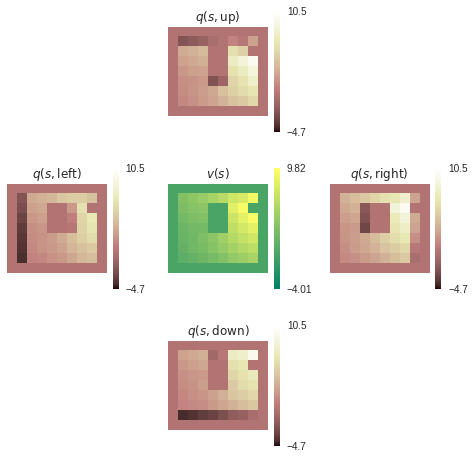

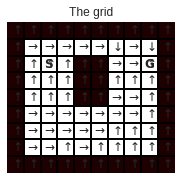

In [79]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(3e4))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

**ExperienceReplay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.6/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


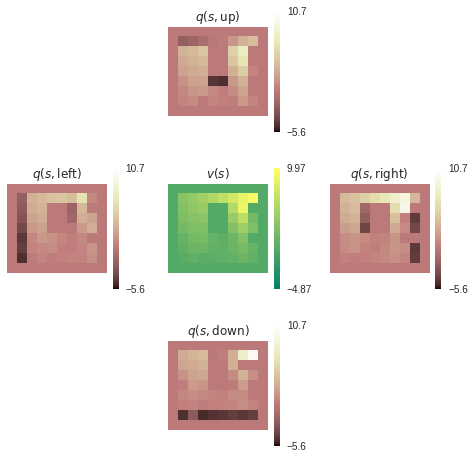

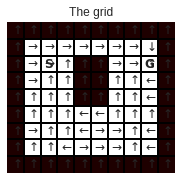

In [86]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

**DynaQ**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.6/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


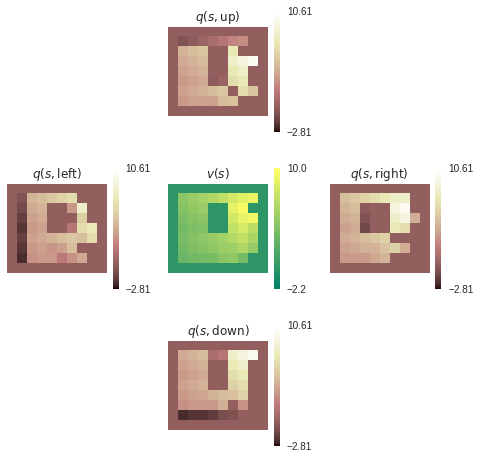

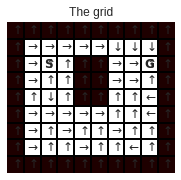

In [93]:
grid = Grid()
dyna_model = TabularModel(grid._layout.size, 4)
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(), dyna_model,
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

## 2.3 Linear function approximation

We will now consider the $\text{FeatureGrid}$ domain.

And evaluate $\text{Q-learning}$, $\text{Experience Replay}$ and $\text{DynaQ}$, in the context of linear function approximation.

All experiments are run for $\text{number_of_steps}$ = $1e5$

**Online Q-learning with Linear Function Approximation**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.6/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


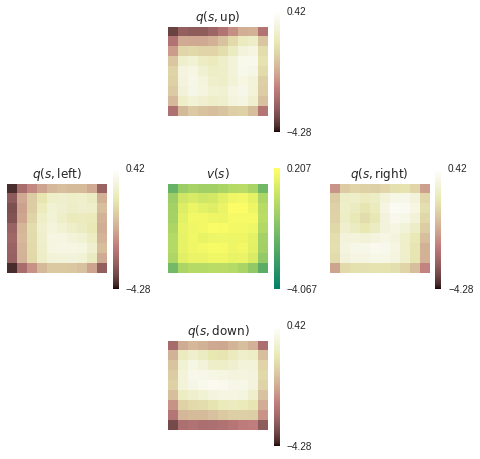

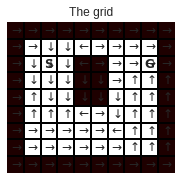

In [95]:
# don't know why that epsilon policy will bring worse result
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

**Experience Replay with Linear Function Approximation**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.6/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


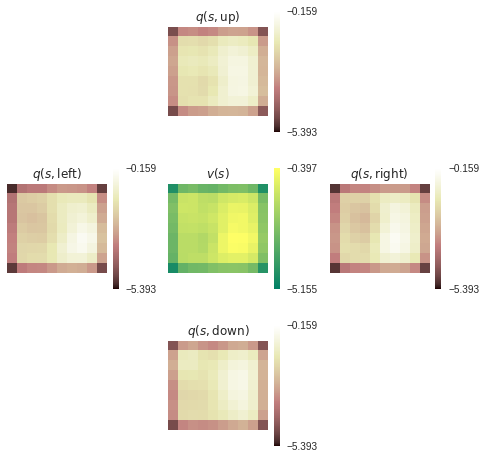

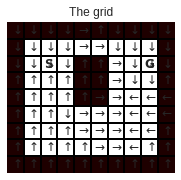

In [100]:
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy= epslon_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

**DynaQ with Linear Function Approximation**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.6/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


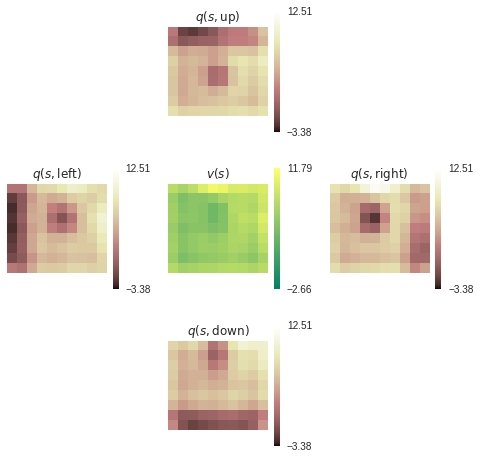

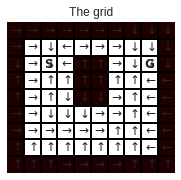

In [20]:
grid = FeatureGrid()

linear_model = LinearModel(grid.number_of_features, 4)


agent = FeatureDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  model = linear_model,
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy,
  )

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

## 2.4 Non stationary Environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left).

The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

In [0]:
pretrain_steps = 2e4
new_env_steps = pretrain_steps / 30

**Online Q-learning**

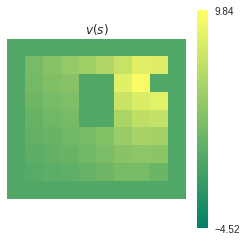

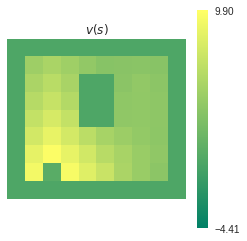

In [71]:
# Train on first environment
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)

# Train on first environment

alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)


**Experience Replay**

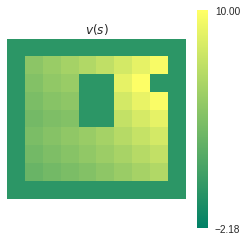

In [105]:
# Train on first environment
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)



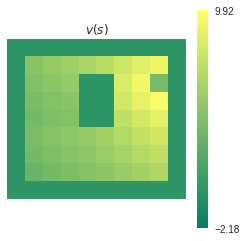

In [106]:
# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

**Dyna**

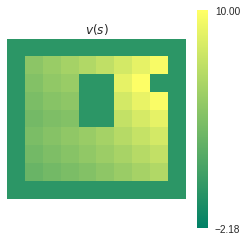

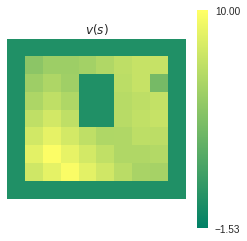

In [78]:
# Train on first environment
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(), dyna_model,
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

## Questions

### Basic Tabular Learning

**[5 pts]** Why is the ExperienceReplay agent so much more data efficient than online Q-learning? </br >
  Because ExperienceReplay has a model to utilize simulated experience to make update instead of only using the real experience from interacting with environment.

**[5 pts]** If we run the experiments for the same number of updates, rather than the same number of steps in the environment, which among online Q-learning and Experience Replay performs better? Why? </br >
  That is because plain online Q learning will waste a lot of updates in achieving nothing changed especially in the first serval episold, since most of the values stay zero expect the one leading to terminal. On the other hand, ExperienceReplay narrows down the scope to the values that are more likely to change.

**[5 pts]** Which among online Q-learning and Dyna-Q is more data efficient? why? </br >
  Dyna-Q is more data efficient because it has a model learning from the real experiences simutaneously, this model records the latest transition of each state from real experience such that it is a unbiased estimate of real environment, and it use this model to generate simulated experience and trains itself on them.

**[5 pts]** If we run the experiments for the same number of updates, rather than the same number of steps in the environment, which among online Q-learning and Dyna-Q performs better? Why? </br >
  The answer will be pretty much similar to the ExperienceReplay's one, dynaQ samples from past path, so it will be much likely to make real update for the state that leads to the goal in the first several episoids instead of wasting a lot of blank update, so it will learn very faster than online Q-learning.

### Linear function approximation

**[5 pts]** The value estimates with function approximation are considerably more blurry than in the tabular setting despite more training steps and interactions with the environment, why is this the case? </br >
  The problem are very common problems in deep reinforcement learning: 1, the training data is not generated from iid, which is a assumption of surpvised learning, due to the policy changes all the time. 2, since approximate function is trained against the value of next state esimated by the same function, the succussor state are generally similar, so parameters could not updated quite well.

**[5 pts]** Inspect the policies derived by training agents with linear function approximation on `FeatureGrid` (as shown by `plot_greedy_policy`). How does this compare to the optimal policy? Are there any inconsistencies you can spot? What is the reason of these? </br >
  Comparing to the optimal policy as achieved by tabalar methonds, there some inconsistencies laid in the linear function apprximation policy, which reflect the fact that under the two problems discussed in the above questions, linear function approximation method are likely to provide suboptimal policy due to the unmet assumption of supervised learning.

### Learning in a non stationary environment

Consider now the tabular but non-stationary setting of section 2.4.

After an initial pretraining phase, the goal location is moved to a new location, where the agent is allowed to train for some (shorter) time.

**[10 pts]** Compare the value estimates of online Q-learning and Experience Replay, after training also on the new goal location, explain what you see.  </br >
  
  Online Q-learning finished correcting its optimal policy with respect to new environment, howerver, ExperienceReplay falls to correcting its policy. Because online Q-learning does not have the process of planning, it will find the high reward of original terminal does not exist anymore and graduatelly adjust the action value driven by the new terminal, while ExperienceReplay have a buffer records the whole history so very likely to update on the majority of wrong data once environment changed, it will be very hard to correcting the policy with keeping making wrong update unless the new coming right data overwhelme the wrong ones.

**[10 pts]** Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location, explain what you see. </ br>
  
  They both switch to right optimal policy very efficiently from which we can see another advantage of dynaQ over experience replay besides memory efficiency. DynaQ use only use a table to record the latest record rather than the buffer, which enable dynaQ to make adjustment with repect to new terminal very quickly once it see the new target from its random policy exploration.

Back up your observations with visualizations of the value/policy.

